# Imports

In [261]:
from __future__ import print_function
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
from numba import njit
from itertools import product

# Sample Data

## Load Data

In [262]:
data_org = pd.read_csv('../data/family_data.csv', index_col='family_id')

In [263]:
# sub = pd.read_csv('/home/takashi/Downloads/best.csv',index_col='family_id')
sub = pd.read_csv('../submissions/l2.csv',index_col='family_id')


In [264]:
te = sub.iloc[:,0].values-1

In [265]:
pena,occ = pcost(te)
acc = acost(occ)
acc,cost_function(te)

((5741.070996885317, 0), 68963.07099688532)

## Extractioin

In [266]:
data = data_org.iloc[0:,:]

In [267]:
mean_occupnacy = data.n_people.sum()/len(data)
print('MEAN OCCUPANCY : ', mean_occupnacy)

MEAN OCCUPANCY :  4.2006


In [268]:
data.shape

(5000, 11)

## Set

In [269]:
N_DAYS = 100
N_FAMILIES = len(data)
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

FAMILY_SIZE = data.n_people.values
DESIRED     = data.values[:, :-1] - 1

In [270]:
# GAP = range(MIN_OCCUPANCY,MAX_OCCUPANCY+1)
# GAP_P = {}
# _C_GAP =20
# for i in GAP:
#     if i <= MIN_OCCUPANCY + 1:
#         GAP_P[i]= range(MIN_OCCUPANCY,MAX_OCCUPANCY+1)
#     else:
#         GAP_P[i]= (range(max(i-(_C_GAP),MIN_OCCUPANCY),min(i+(_C_GAP),MAX_OCCUPANCY+1)))

In [271]:
# Constraints
GAP = range(MIN_OCCUPANCY,MAX_OCCUPANCY+1)
GAP_P = {}
for i in GAP:
    GAP_P[i]=GAP
# for i in GAP:
#     if i <= MIN_OCCUPANCY + 1:
#         GAP_P[i]= range(MIN_OCCUPANCY,MAX_OCCUPANCY+1)
#     else:
#         GAP_P[i]= (range(max(i-(_C_GAP),MIN_OCCUPANCY),min(i+(_C_GAP),MAX_OCCUPANCY+1)))

In [272]:
GAP_P[300]

range(125, 301)

# Cost Function

## Preference Cost

### Preference Cost Function

In [273]:
def get_penalty(n, choice):
    penalty = None
    if choice == 0:
        penalty = 0
    elif choice == 1:
        penalty = 50
    elif choice == 2:
        penalty = 50 + 9 * n
    elif choice == 3:
        penalty = 100 + 9 * n
    elif choice == 4:
        penalty = 200 + 9 * n
    elif choice == 5:
        penalty = 200 + 18 * n
    elif choice == 6:
        penalty = 300 + 18 * n
    elif choice == 7:
        penalty = 300 + 36 * n
    elif choice == 8:
        penalty = 400 + 36 * n
    elif choice == 9:
        penalty = 500 + 36 * n + 199 * n
    else:
        penalty = 500 + 36 * n + 398 * n
    return penalty

In [274]:
def GetPreferenceCostMatrix(data):
    cost_matrix = np.zeros((N_FAMILIES, N_DAYS), dtype=np.int64)
    for i in range(N_FAMILIES):
        desired = data.values[i, :-1]
        cost_matrix[i, :] = get_penalty(FAMILY_SIZE[i], 10)
        for j, day in enumerate(desired):
            cost_matrix[i, day-1] = get_penalty(FAMILY_SIZE[i], j)
    return cost_matrix

### Make Matrix

In [275]:
PCOSTM = GetPreferenceCostMatrix(data)

In [276]:
get_penalty(1,51)

934

In [277]:
PCOSTM[PCOSTM<1500].shape

(112679,)

(5000, 100)


/home/takashi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


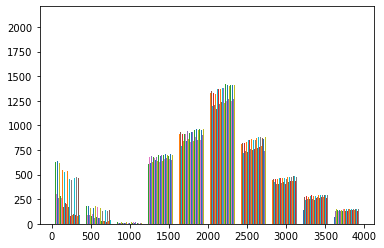

In [278]:
print(PCOSTM.shape)
np.histogram(PCOSTM)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(PCOSTM,bins=10)
fig.show()

### Calculate Preference Cost

In [279]:
@njit(fastmath=True)
def pcost(prediction):
    daily_occupancy = np.zeros(N_DAYS+1, dtype=np.int64)
    penalty = 0
    for (i, p) in enumerate(prediction):
        n = FAMILY_SIZE[i]
        penalty += PCOSTM[i, p]
        daily_occupancy[p] += n
    return penalty, daily_occupancy

## Accounting Cost

In [280]:
def GetAccountingCostMatrix():
    ac = np.zeros((MAX_OCCUPANCY+1, MAX_OCCUPANCY+1), dtype=np.float64)
    for n in range(ac.shape[0]):
        for n_p1 in range(ac.shape[1]):
            diff = abs(n - n_p1)
            ac[n, n_p1] = max(0, (n - MIN_OCCUPANCY) / 400 * n**(0.5 + diff / 50.0))
#             ac[n, n_p1] = max(0, (n - 2) / 8 * n**(0.5 + diff))
    return ac

### Make Matirx

In [281]:
ACOSTM = GetAccountingCostMatrix() 

In [282]:
print(ACOSTM.shape)
ACOSTM[225][225]

(301, 301)


3.75

In [283]:
# ACOSTM = (np.round(ACOSTM,decimals=2) * 10).astype(np.int32)
# PCOSTM = PCOSTM*10

### Accounting Cost

In [284]:
@njit(fastmath=True)
def acost(daily_occupancy):
    accounting_cost = 0
    n_out_of_range = 0
    daily_occupancy[-1] = daily_occupancy[-2]
    for day in range(N_DAYS):
        n_p1 = daily_occupancy[day + 1]
        n    = daily_occupancy[day]
        n_out_of_range += (n > MAX_OCCUPANCY) or (n < MIN_OCCUPANCY)
        accounting_cost += ACOSTM[n, n_p1]
    return accounting_cost, n_out_of_range

## Total Cost

In [285]:
@njit(fastmath=True)
def cost_function(prediction):
    penalty, daily_occupancy = pcost(prediction)
    accounting_cost, n_out_of_range = acost(daily_occupancy)
    return penalty + accounting_cost + n_out_of_range*100000000

## Evaluation Method

In [286]:
def eval(prediction):
    pc, occ = pcost(prediction)
    ac, _ = acost(occ)
    print('Preferenced Cost : ', pc)
    print('Accounting Cost : {: .2f}'.format(ac))
    print('Total Cost : {: .2f}'.format(pc+ac))
    print('')
    print('Max Occupancy : {} , Min Ocupancy : {}'.format(occ.max(), occ.min()))

# Minimize Practice

## Solver

In [287]:
DESIRED.shape

(5000, 10)

In [288]:
X_days = {}
NO_OTHER = False
P_CUTOFF = 15000
for f in range(N_FAMILIES):
    if NO_OTHER :
        X_days[f] = DESIRED[f,:]
    else:
        X_days[f] = []
        for d in range(N_DAYS):
            if(PCOSTM[f][d] < P_CUTOFF):
                X_days[f].append(d)


In [289]:
sum([len(X_days[f]) for f in range(N_FAMILIES)])

500000

In [290]:
def make_IP():
    S = pywraplp.Solver('SolveAssignmentProblem', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
#     S = pywraplp.Solver('SolveAssignmentProblem', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)    
#     GAP = MAX_OCCUPANCY-MIN_OCCUPANCY + 1
    
    candidates = [[] for _ in range(N_DAYS)] 
    
    x = {}
    for i in range(N_FAMILIES):
        for j in X_days[i]:
#         for j in range(N_DAYS):
            candidates[j].append(i)
            x[i, j] = S.BoolVar('x[%i,%i]' % (i, j))
#         for make xml
            if(te[i]==j):
                S.Add(x[i,j]==1)
            else:
                S.Add(x[i,j]==0)
    
    N = {}
    for day in range(N_DAYS):
        for i in GAP:
            for j in GAP_P[i]:
                N[day, i, j] = S.BoolVar('N[%i,%i,%i]' % (day, i, j))
#             for j in GAP:
#                 N[day, i, j] = S.BoolVar('N[%i,%i,%i]' % (day, i, j))
            

    family_presence = [S.Sum([x[i, j] for j in X_days[i]]) for i in range(N_FAMILIES)]
    
    linear_constraint = [S.Sum([N[day, i, j] for i in GAP for j in GAP_P[i]]) for day in range(N_DAYS) ]
    
    daily_occupancy_x = [S.Sum([x[i, j] * FAMILY_SIZE[i] for i in candidates[j]]) for j in range(N_DAYS)]
    
#     daily_occupancy_n = [S.Sum( [(i)* N[day, i, j] for i in GAP
#                                                                                                                                                                            for j in GAP_P[i]] )
#                                                                                                                                                                            for day in range(N_DAYS)]
    
 
        
    # Objective    
    partial_costs = [PCOSTM[i, j] * x[i,j] for i in range(N_FAMILIES) for j in X_days[i] ]
    preference_cost = S.Sum(partial_costs)
    
    penalties = []
    for day in range(N_DAYS):
        for i in GAP:
            for j in GAP_P[i]:
                daily_occupancy = i
                p_occupancy = j
#                 penalties.append(abs(daily_occupancy - MIN_OCCUPANCY)/400 
#                                  * daily_occupancy**(1/2+abs(daily_occupancy - p_occupancy)/50) 
#                                  * N[day, daily_occupancy, p_occupancy])
                penalties.append(N[day,i,j]* ACOSTM[i,j])

    accounting_penalty = S.Sum(penalties)
    
    total_cost = S.Sum([preference_cost,accounting_penalty])
#     total_cost = preference_cost + accounting_penalty

    S.Minimize(total_cost)
#     S.Minimize(accounting_penalty)
#     S.Minimize(preference_cost)


# 
    for day in range(N_DAYS):
        for i in GAP:
            for j in GAP_P[i]:
                if ACOSTM[i][j] > 1200:
                    S.Add(N[day,i,j] == 0)
    # Constraints
    
    
    for day in range(N_DAYS):
        S.Add(linear_constraint[day] == 1)
        S.Add(
#         daily_occupancy_x[day] - daily_occupancy_n[day] == 0
            S.Sum([N[day, i, j]*(i) for i in GAP for j in GAP_P[i]]) 
                == daily_occupancy_x[day]
        )       

    for day in range(N_DAYS-1):
        S.Add(
            S.Sum([N[day, i, j]*(j) for i in GAP for j in GAP_P[i]]) 
                == daily_occupancy_x[day+1]
        ) 
    for day in range(N_DAYS-1):
        for t in GAP:
            sum_u = S.Sum([N[day,u,t] for u in GAP])
            sum_v = S.Sum([N[day+1,t,v] for v in GAP])
            S.Add(sum_u == sum_v)
        
#         S.Add(daily_occupancy_n[day] == 0)
        
    for i in range(N_FAMILIES):
        S.Add(family_presence[i] == 1)
    
        
#     S.Add(accounting_penalty >= 5447)
#     for day in range(N_DAYS):
#         for i in range(MIN_OCCUPANCY):
#             for j in range(MIN_OCCUPANCY):
#                 if abs(i - j)
    
        
# #         差の条件を加えてみる
#     for j in range(N_DAYS-1):
#         S.Add(daily_occupancy[j]   - daily_occupancy[j+1] <= 23)
#         S.Add(daily_occupancy[j+1] - daily_occupancy[j]   <= 23)
            
        

    print('ready !!')
    return S

In [291]:
S = make_IP()

KeyboardInterrupt: 

In [ ]:
lp = S.ExportModelAsMpsFormat(False,False)

In [ ]:
with open('santa_cut.mps', 'w') as f:
  print(lp, file=f)

In [ ]:
# res = S.Solve()
# resdict = {0:'OPTIMAL', 1:'FEASIBLE', 2:'INFEASIBLE', 3:'UNBOUNDED', 
#            4:'ABNORMAL', 5:'MODEL_INVALID', 6:'NOT_SOLVED'}

# print('IP solver result:', resdict[res])


# l = [(i, j, x[i, j].solution_value()) for i in range(N_FAMILIES)
#                                                   for j in X_days[i] 
#                                                   if x[i, j].solution_value()>0]


# df = pd.DataFrame(l, columns=['family_id', 'day', 'n'])


## Solve

In [ ]:
# %%time
# df_tmp = IP()

## Check

In [27]:
df_tmp.shape

NameError: name 'df_tmp' is not defined

In [ ]:
eval(df_tmp.day.values)

In [ ]:
pc, occ = pcost(df_tmp.day.values)
print(occ)

In [ ]:
ans = df_tmp.day.values

In [ ]:
ans[69]

In [ ]:
print(df_tmp.day.values)